In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)

css_styling()

In [ ]:
!pip install scikit-learn

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

### Perspective transform

In [16]:
img = cv.imread("./src/warp2.jpg")

In [17]:
_, thr = cv.threshold(
    cv.cvtColor(img, cv.COLOR_BGR2GRAY),
    0,
    255,
    cv.THRESH_BINARY + cv.THRESH_OTSU
)

In [18]:
contours, hier = cv.findContours(thr, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

In [21]:
imgcp = img.copy()
cv.drawContours(imgcp, contours, -1, (0, 255, 0), thickness=2)
len(contours)

1

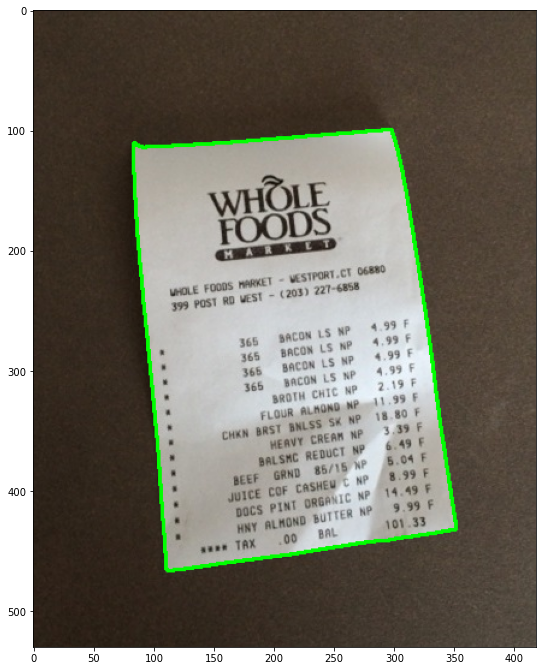

In [20]:
plt.figure(figsize=(9, 12))
plt.imshow(cv.cvtColor(imgcp, cv.COLOR_BGR2RGB))
plt.show()

#### Approximate contour to 4 points

In [23]:
for cnt in contours:
    perimeter = cv.arcLength(cnt, True)
    approx = cv.approxPolyDP(cnt, 0.05*perimeter, True)

print(approx)

[[[297  99]]

 [[ 83 111]]

 [[111 466]]

 [[351 431]]]


In [33]:
input_pts = np.float32(approx)
output_pts = np.float32((
    [0, 0],
    [0, 500],
    [800, 500],
    [800, 0],
))

In [34]:
# Gives perspective transform matrix
MAT = cv.getPerspectiveTransform(input_pts, output_pts)

In [35]:
out = cv.warpPerspective(imgcp, MAT, (800, 500))

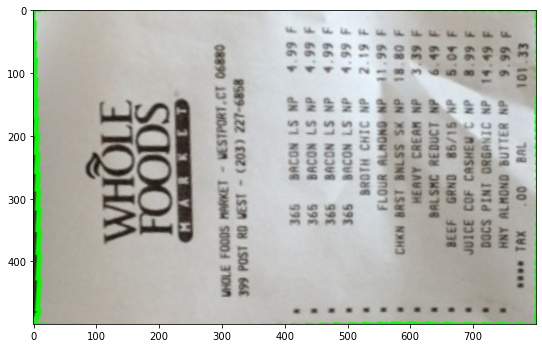

In [36]:
plt.figure(figsize=(9, 12))
plt.imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB))
plt.show()

### Histogram

In [3]:
imgj = cv.imread("../static/rz-1.jpg")
h, w, c = imgj.shape

In [4]:
hist_blue = cv.calcHist([imgj], [0], None, histSize=[256], ranges=[0, 256])
hist_green = cv.calcHist([imgj], [1], None, histSize=[256], ranges=[0, 256])
hist_red = cv.calcHist([imgj], [2], None, histSize=[256], ranges=[0, 256])

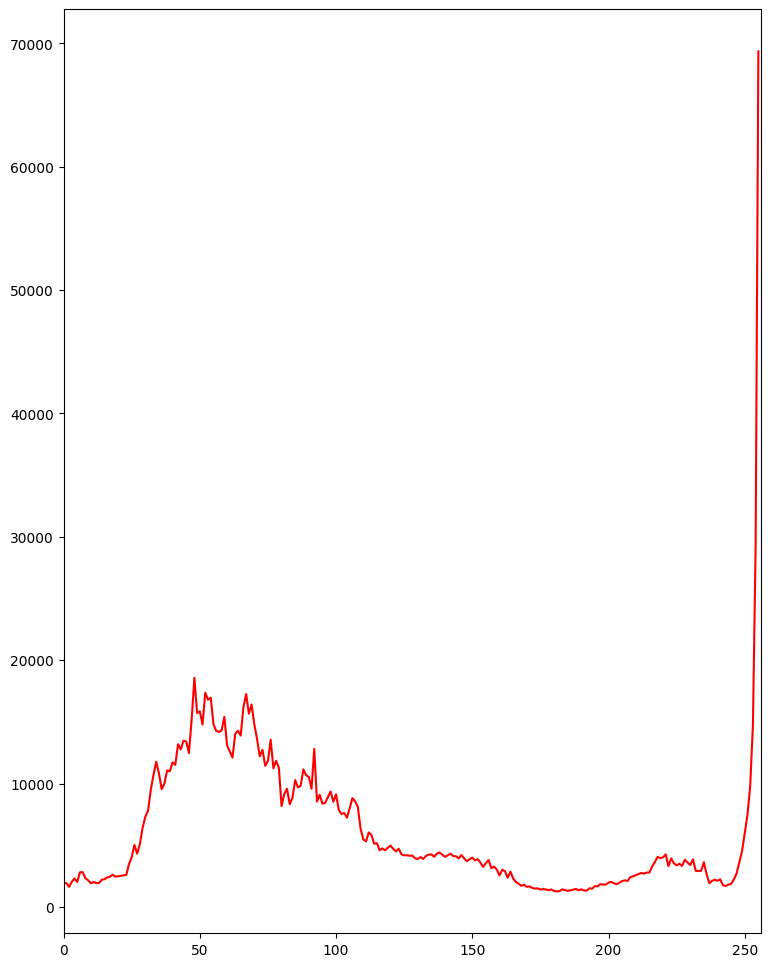

In [5]:
plt.figure(figsize=(9, 12))
plt.plot(hist_red, color='r')
plt.xlim([0, 256])
plt.show()

### KMeans

In [6]:
def centroid_histogram(clt):
    """
    Create a histrogram for the clusters based on the pixels in each cluster
    Get the labels for each cluster
    """
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)
    hist = hist.astype("float")
    hist /= hist.sum()

    return hist

def plot_colors(hist, centroids):
    bar = np.zeros((100, 500, 3), dtype="uint8")
    x_start = 0

    for (percent, color) in zip(hist, centroids):
        end = x_start + (percent * 500)
        cv.rectangle(bar, (int(x_start), 0), (int(end), 100),
        color.astype("uint8").tolist(), -1)
        x_start = end
    return bar

In [10]:
from sklearn.cluster import KMeans

In [11]:
imgj_flattened = cv.cvtColor(imgj, cv.COLOR_BGR2RGB).reshape((h*w, c))
clt = KMeans(5)
clt.fit(imgj_flattened)
hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)

C:\Users\Harry\Documents\DS\Modern-CV-Rejeev-D-Ratan-Udemy\openvino-qat\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Harry\Documents\DS\Modern-CV-Rejeev-D-Ratan-Udemy\openvino-qat\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


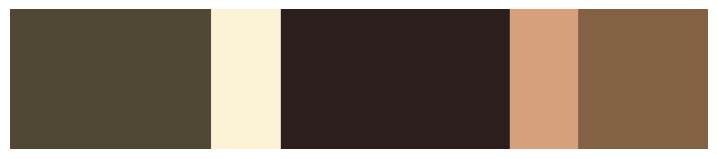

In [12]:
plt.figure(figsize=(9, 12))
plt.imshow(bar)
plt.axis("off")
plt.show()

### Filter on colors

In [13]:
lower = np.array([35, 0, 0])
upper = np.array([80, 255, 255])

hsv_img = cv.cvtColor(imgj, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_img, lower, upper)
res = cv.bitwise_and(imgj, imgj, mask=mask)
res2 = cv.bitwise_and(imgj, imgj, mask=cv.bitwise_not(mask))

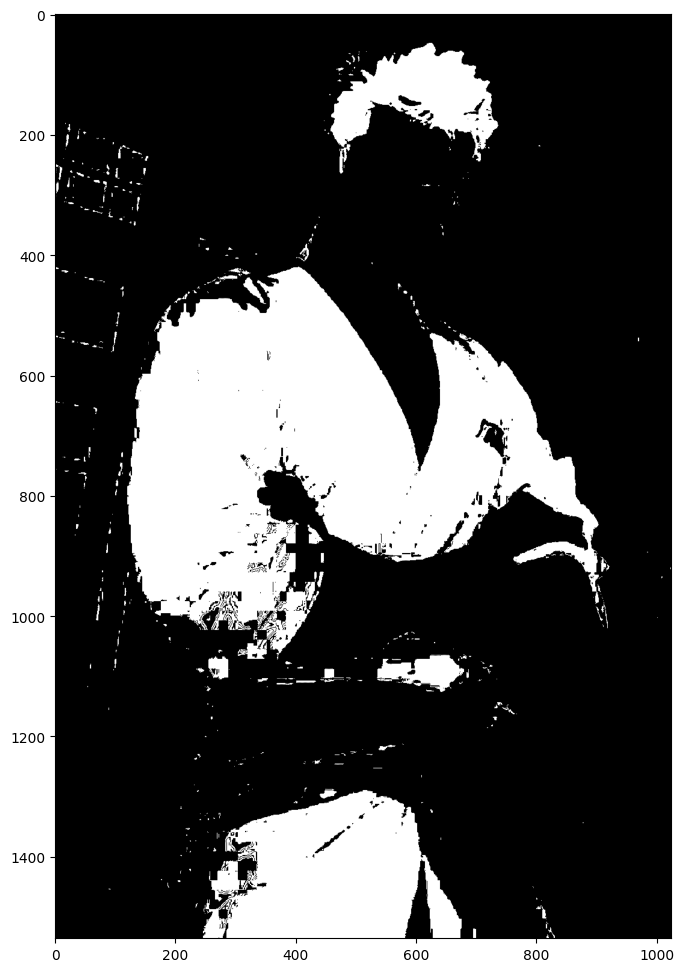

In [14]:
plt.figure(figsize=(9, 12))
plt.imshow(cv.cvtColor(mask, cv.COLOR_BGR2RGB))
plt.show()

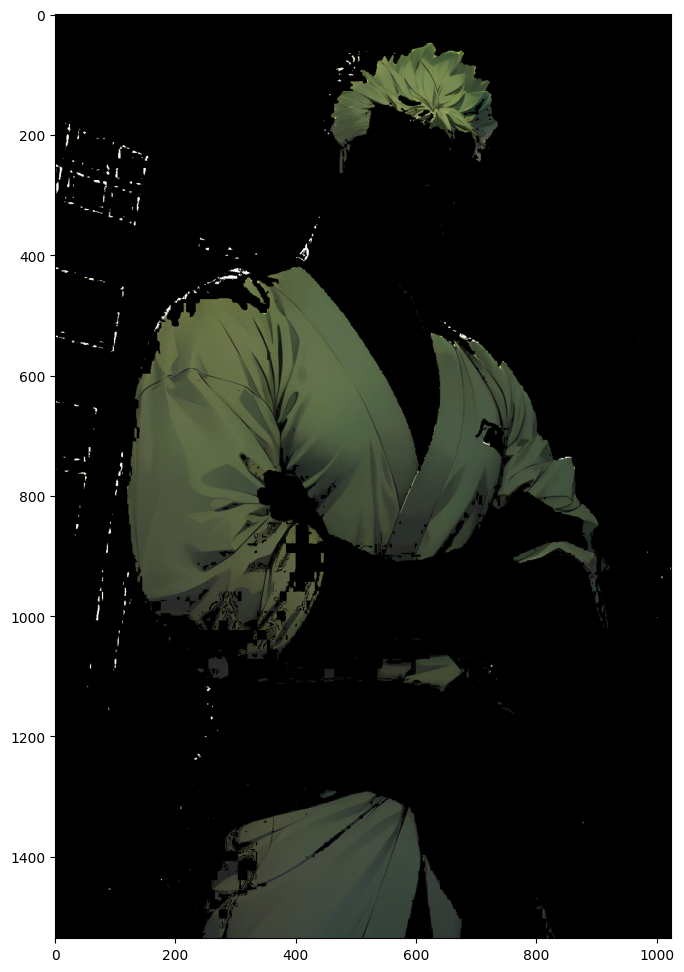

In [15]:
plt.figure(figsize=(9, 12))
plt.imshow(cv.cvtColor(res, cv.COLOR_BGR2RGB))
plt.show()

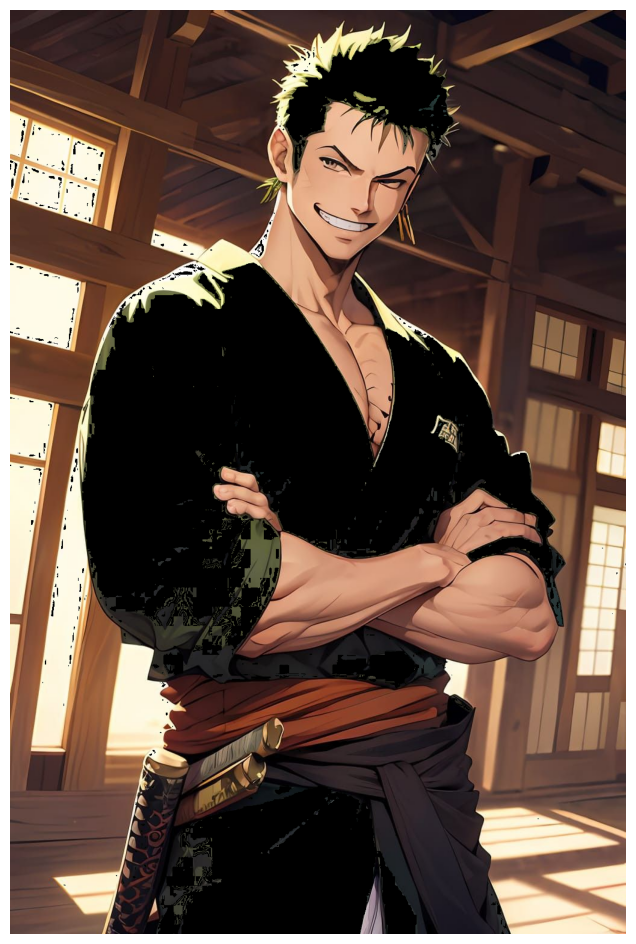

In [16]:
plt.figure(figsize=(9, 12))
plt.imshow(cv.cvtColor(res2, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

### Background and foreground subtraction